Notes for Jacopo:


*   Cosa possiamo dire dell'evoluzione dell'IAT
*   Cosa possiamo dire dell'alterazione dell'IAT, all'incontro con un commento tossico.
Analizziamo per ogni utente in un thread, come  l'interarrival time tende a incrementare e se è legato a qualcosa che accade nell'intorno.




<br>
This EDAA  is for Walter, in order to find togheter a mattern or a signal that needs to be investigated<br>


In [1]:
kernel='j'

In [2]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/EDA'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from EDA_package.function import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

Cloning into 'thesis'...
remote: Enumerating objects: 464, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 464 (delta 79), reused 53 (delta 22), pack-reused 320
Receiving objects: 100% (464/464), 27.67 MiB | 25.46 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Mounted at /content/drive


In [3]:
import sys
import os
import numpy as np
module_path = '/Users/jacoponudo/Documents/thesis/src/EDA'
sys.path.append(module_path)
from EDA_package.function import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.stats import chi2_contingency

In [4]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

# IAT Valley


*Escludiamo le interazione con meno di 3 commenti, calcoliamo la posizione rispetto all'inizio e la fine della conversazione ∈ [0,1]*

In [ ]:
data=data[data['number_of_comments_by_user_in_thread']>5].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

*L'IAT non è omogeneo nella conversazone.
Notiamo che l'inter arrival time tende a crescere nella fase finale della conversazione, l'utente si stufa, risponde sempre meno prontamente, fino a uscire.*

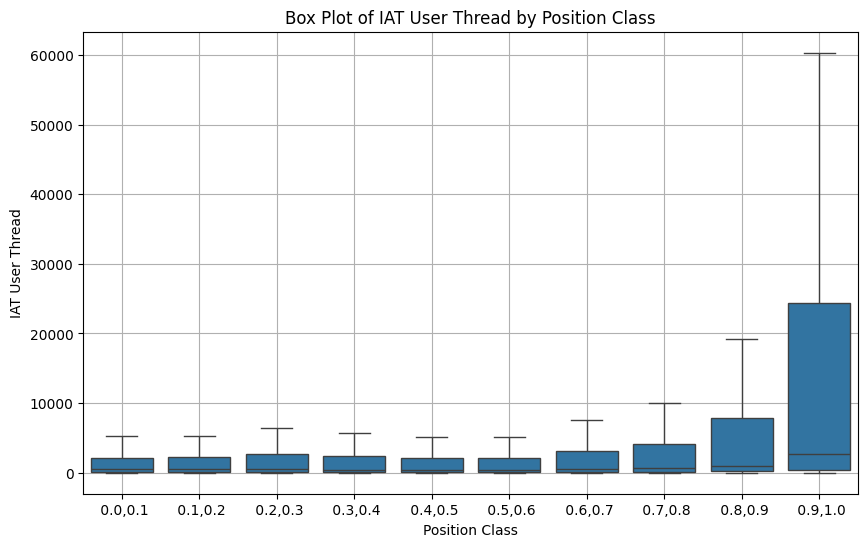

In [ ]:
number_of_classes=10
data['position_class'] = pd.cut(data['position_user_thread'], bins=number_of_classes, labels=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x='position_class', y='IAT_user_thread', data=data,showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class')
plt.xlabel('Position Class')
plt.ylabel('IAT User Thread')
plt.xticks(ticks=range(number_of_classes), labels=[f' {i/number_of_classes},{(i+1)/number_of_classes}' for i in range(number_of_classes)])
plt.grid(True)
plt.show()

*Osserviamo come se la fase finale della conversazione risulta piu rilassata, con ritmi piu flebili, la conversazione tende ad essere meno tossica.*


<ipython-input-113-0baa397849f8>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=False, palette='Set1')


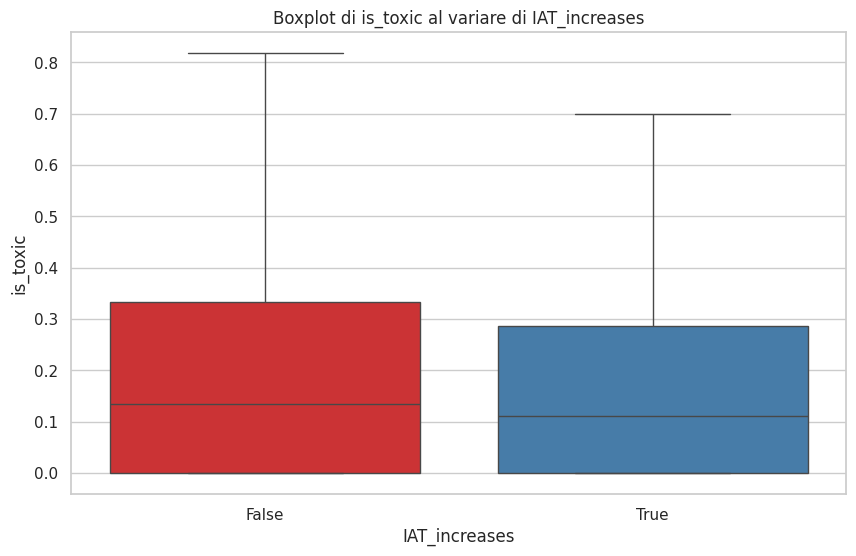

In [ ]:
# Trova l'IAT mediana e finale di ogni conversazione per ogni utente
mean_IAT = data.groupby(['user', 'root_submission'])['IAT_user_thread'].median().reset_index()
final_IAT = data[data['position_class'].isin([number_of_classes-1])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()
semifinal_IAT = data[data['position_class'].isin([number_of_classes-2])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()

# Unisci i due DataFrame sulla chiave 'user' e 'root_submission'
merged_df = mean_IAT.merge(final_IAT, on=['user', 'root_submission'], suffixes=('_median', '_final'))
merged_df = merged_df.merge(semifinal_IAT, on=['user', 'root_submission'], suffixes=('', '_semifinal'))

merged_df['IAT_increases'] = (merged_df['IAT_user_thread_final'] > 1.5*(merged_df['IAT_user_thread_median'])) & ( merged_df['IAT_user_thread'] > 1.2*(merged_df['IAT_user_thread_median']))


data['is_toxic']=data['toxicity_score']>0.6
toxicity=data.groupby(['user','root_submission'])['is_toxic'].mean()

merged_df=merged_df.merge(toxicity,on=['user', 'root_submission'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=False, palette='Set1')
plt.title('Boxplot di is_toxic al variare di IAT_increases')
plt.xlabel('IAT_increases')
plt.ylabel('is_toxic')
plt.show()

Il valley pattern, ultimi commenti meno vivaci diopende anche dall'utente? Si tdistribuiscono in maniera omogenea?

# Quanti siamo e quanto Parlo

Meno è affollata la conversazione nell'intorno di un commento piu lunga sarà l'interazione user-thread a cui il commeento appartiene.

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

In [ ]:
from datetime import datetime, timedelta


df=data
# Convertire la colonna 'created_at' in formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])
results = []


for i,row in tqdm(df.iterrows(),total=len(df)):
  # Selezionare una riga
  riga_selezionata = row

  # Estrarre il valore di 'created_at'
  valore_created_at = riga_selezionata['created_at']

  # Calcolare l'intervallo di tempo di 10 minuti
  delta_tempo = timedelta(minutes=30)

  # Calcolare l'intervallo di tempo entro 10 minuti in più e in meno rispetto a 'created_at'
  time_range_start = ((valore_created_at - delta_tempo))
  time_range_end =( (valore_created_at + delta_tempo))

  # Creare una maschera booleana per filtrare tra le due date
  mask = (df['created_at'] >= time_range_start) & (df['created_at'] <= time_range_end)

  filtered_df = df.loc[mask]

  y=len(filtered_df.user.unique())
  x=riga_selezionata.IAT_user_thread
  results.append({'x': x, 'y': y})

# Convertire la lista dei risultati in un DataFrame
results_df = pd.DataFrame(results)
results_df.dropna(inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Standardizzazione dei dati
scaler = StandardScaler()
results_df[['x', 'y']] = scaler.fit_transform(results_df[['x', 'y']])

# Creazione del modello di regressione lineare
model = LinearRegression()
model.fit(results_df[['x']], results_df['y'])

# Previsione dei valori di y
results_df['y_pred'] = model.predict(results_df[['x']])

# Tracciamento del diagramma a dispersione con la retta di regressione
plt.figure(figsize=(10, 6))
plt.scatter(results_df['x'], results_df['y'], alpha=0.5, label='Dati standardizzati')
plt.plot(results_df['x'], results_df['y_pred'], color='red', label='Retta di regressione')
plt.title('Diagramma a dispersione di x e y con retta di regressione')
plt.xlabel('Standardized x')
plt.ylabel('Standardized y')
plt.legend()
plt.grid(True)
plt.show()

,x,y,y_pred
1,-0.024924,1.467494,0.000381
3,60.546867,-1.006150,-0.925745
4,28.037073,-0.511422,-0.428679
6,63.500314,-1.006150,-0.970903
7,123.404193,-1.006150,-1.886817
...,...,...,...
79956,-0.048024,-0.511422,0.000734
79957,-0.048048,-0.511422,0.000735
79958,-0.048022,-0.511422,0.000734
79959,-0.047601,-1.006150,0.000728


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

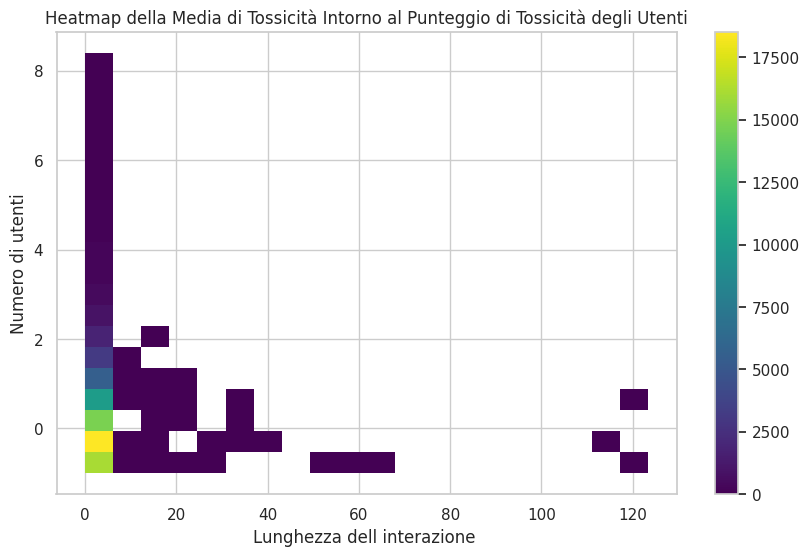

In [ ]:
scaler = StandardScaler()
results_df[['x', 'y']] = scaler.fit_transform(results_df[['x', 'y']])

plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='x', y='y', bins=20, cmap='viridis', cbar=True)
plt.title('Heatmap della Media di Tossicità Intorno al Punteggio di Tossicità degli Utenti')
plt.xlabel('Lunghezza dell interazione ')
plt.ylabel('Numero di utenti')
plt.colorbar(label='Frequenza')
plt.show()

# Toxicità nell'intorno

Analizziamo se un commento tossico, nel suo intorno è circondato da commenti tossici. I seguenti risultati sono ottenuti usando un intorno di raggio 2. Mostrano che esiste una correlazione tra il livello di tossicità e l'intorno temporale di una conversazione.
Questo però non tiene conto che in alcune piattaforme le conversazioni si ramificano.

In [ ]:
data_sorted = data.sort_values(by='created_at').reset_index(drop=True)
#data_sorted=data_sorted[data_sorted['sequential_number_of_comment_by_user_in_thread']>1]



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creazione di DataFrame vuoti per x e y
x = []
y = []
z = []
j = []


r=5

# Iterazione sul DataFrame data_sorted
for i, row in tqdm(data_sorted.iterrows(),total=len(data_sorted)):
    iat = row['toxicity_score']
    created_at = row['created_at']

    df=data_sorted[data_sorted['root_submission']==row['root_submission']].reset_index()

    i=(df['created_at'] == created_at).idxmax()
    mean_iat = np.mean(df.loc[i - r:i + r+1, 'toxicity_score'].drop(i))
    mean_j = np.mean(df.loc[i - r:i + r+1, 'IAT_user_thread'].drop(i))


    # Aggiungi i valori a x e y solo se non sono NaN o non numerici
    if pd.notna(iat) and pd.notna(mean_iat) and np.isfinite(mean_iat):
        x.append(iat)
        y.append(mean_iat)
        z.append(row['IAT_user_thread'])
        j.append(mean_j)

scatter_df = pd.DataFrame({'IAT': z, 'Mean_IAT_intorno': j,'Toxicity': x,'Toxicity intorno':y})
scatter_df
# Creazione dello scatterplot con il modello lineare
plt.figure(figsize=(10, 6))
sns.regplot(x='IAT', y='Mean_IAT_intorno', data=scatter_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di IAT_user_thread vs Media di IAT_user_thread con Modello Lineare')
plt.show()

# Creazione dello scatterplot con il modello lineare
plt.figure(figsize=(10, 6))
sns.regplot(x='Toxicity', y='Toxicity intorno', data=scatter_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di IAT_user_thread vs Media di IAT_user_thread con Modello Lineare')
plt.show()


In [ ]:
data_sorted = data.sort_values(by='created_at').reset_index(drop=True)
#data_sorted=data_sorted[data_sorted['sequential_number_of_comment_by_user_in_thread']>1]
data_sorted=data_sorted.sample(100000)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creazione di DataFrame vuoti per x e y
x = []
y = []
z = []
j = []


r=2

# Iterazione sul DataFrame data_sorted
for i, row in tqdm(data_sorted.iterrows(),total=len(data_sorted)):
    iat = row['toxicity_score']
    created_at = row['created_at']

    df=data_sorted[data_sorted['root_submission']==row['root_submission']].reset_index()

    i=(df['created_at'] == created_at).idxmax()
    mean_iat = np.mean(df.loc[i - r:i + r+1, 'toxicity_score'].drop(i))
    mean_j = np.mean(df.loc[i - r:i + r+1, 'IAT_user_thread'].drop(i))


    # Aggiungi i valori a x e y solo se non sono NaN o non numerici
    if pd.notna(iat) and pd.notna(mean_iat) and np.isfinite(mean_iat):
        x.append(iat)
        y.append(mean_iat)
        z.append(row['IAT_user_thread'])
        j.append(mean_j)

scatter_df = pd.DataFrame({'IAT': z, 'Mean_IAT_intorno': j,'Toxicity': x,'Toxicity intorno':y})
scatter_df

# Creazione dello scatterplot con il modello lineare
plt.figure(figsize=(10, 6))
sns.regplot(x='Toxicity', y='Toxicity intorno', data=scatter_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di IAT_user_thread vs Media di IAT_user_thread con Modello Lineare')
plt.show()


,IAT,Mean_IAT_intorno,Toxicity,Toxicity intorno
0,NaN,1973.600000,0.877870,0.325026
1,6228.0,757.200000,0.403369,0.404004
2,1719.0,1646.500000,0.649120,0.326053
3,419.0,4559.428571,0.179840,0.373300
4,NaN,10082.000000,0.450906,0.310936
...,...,...,...,...
1811,264.0,693.500000,0.048595,0.070040
1812,110.0,669.555556,0.023435,0.136401
1813,495.0,581.800000,0.061049,0.143952
1814,398.0,594.200000,0.128675,0.147413


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

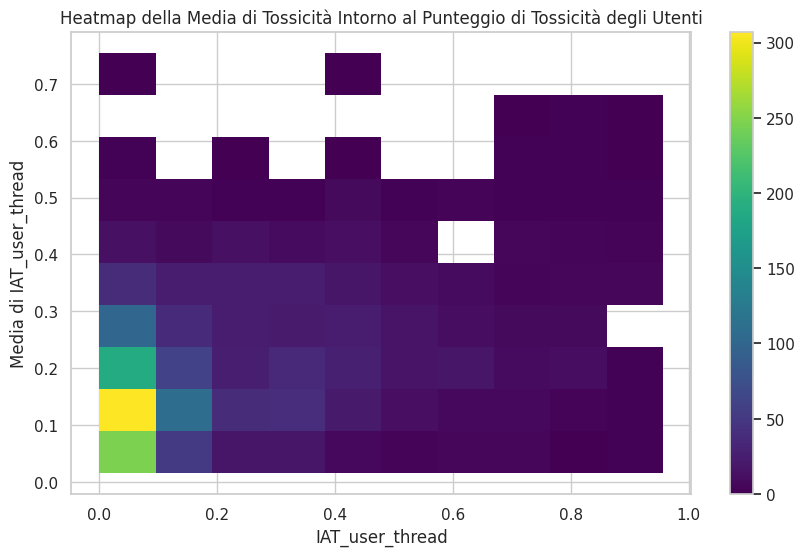

In [ ]:
data.columns
plt.figure(figsize=(10, 6))
sns.histplot(data=scatter_df, x='Toxicity', y='Toxicity intorno', bins=10, cmap='viridis', cbar=True)
plt.title('Heatmap della Media di Tossicità Intorno al Punteggio di Tossicità degli Utenti')
plt.xlabel('IAT_user_thread')
plt.ylabel('Media di IAT_user_thread')
plt.colorbar(label='Frequenza')
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

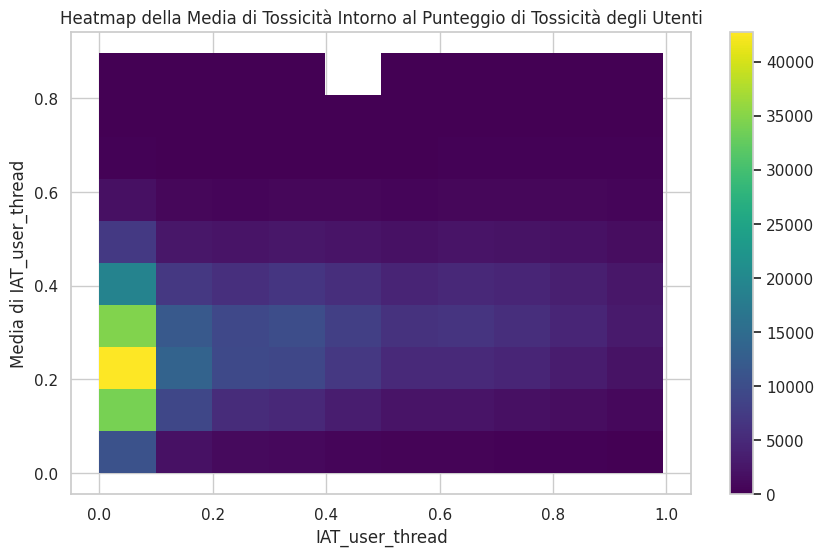

In [ ]:
# Creazione del heatmap
scatter_df['Toxicity intorno'] = pd.to_numeric(scatter_df['Toxicity intorno'], errors='coerce')
scatter_df = scatter_df.dropna(subset=['Toxicity intorno'])
plt.figure(figsize=(10, 6))
sns.histplot(data=scatter_df, x='Toxicity', y='Toxicity intorno', bins=10, cmap='viridis', cbar=True)
plt.title('Heatmap della Media di Tossicità Intorno al Punteggio di Tossicità degli Utenti')
plt.xlabel('IAT_user_thread')
plt.ylabel('Media di IAT_user_thread')
plt.colorbar(label='Frequenza')
plt.show()



Quanto l'arrivo di un commento tossico destabilizza la conversazione?



In [ ]:
from datetime import datetime, timedelta


df=data
# Convertire la colonna 'created_at' in formato datetime
df['created_at'] = pd.to_datetime(df['created_at'])

df=df[df['toxicity_score']>0.6]
results = []


for i,epicentro in tqdm(df.iterrows(),total=len(df)):

  # Estrarre il valore di 'created_at'
  time_epicentro = epicentro['created_at']

  # Calcolare l'intervallo di tempo di 10 minuti
  delta_tempo = timedelta(minutes=120 )

  # Calcolare l'intervallo di tempo entro 10 minuti in più e in meno rispetto a 'created_at'
  time_range_start = ((time_epicentro - delta_tempo))
  time_range_end =( (time_epicentro + delta_tempo))

  # Creare una maschera booleana per filtrare tra le due date
  mask_pre = (df['created_at'] >= time_range_start) & (df['created_at'] <= time_epicentro) & (df['root_submission'] == epicentro['root_submission'])
  mask_post= (df['created_at'] >= time_epicentro) & (df['created_at'] <= time_range_end) & (df['root_submission']== epicentro['root_submission'])

  pre_users = set(df.loc[mask_pre].user)
  post_users= set(df.loc[mask_post].user)

  intersection_users = pre_users.intersection(post_users)
  users_to_remove = set([epicentro['user']])
  final_users = intersection_users.difference(users_to_remove)
  initial_users = pre_users.difference(users_to_remove)


  y=epicentro['comment_id']
  if len(initial_users)==0:
    x='nan'
  else:
    x=len(final_users)/len(initial_users)
  results.append({'x': x, 'y': y})

# Convertire la lista dei risultati in un DataFrame
results_df = pd.DataFrame(results)
results_df.dropna(inplace=True)

100%|██████████| 14688/14688 [01:28<00:00, 166.38it/s]


Controlliamo se all'arrivo di un commento molto tossico, superiore al 75 %, il compoertamento dell'utente tende a cambiare. Per ciascun utente presente prima del **epicentro**, valutiamo il numero di commenti e l'IAT.
Facciamo lo stesso in seguito, e vediamo se la conversazione si *velocizza* individualmente. La risposta è assolutamente no, il numero di commenti per utente rimane ugualemente disttribuito prima e dopo il picco.

In [ ]:
import pandas as pd
from tqdm import tqdm
from datetime import timedelta

# Convert the 'created_at' column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Filter the DataFrame for rows where 'toxicity_score' is greater than 0.6
df = df[df['toxicity_score'] > 0.95]

results = []

# Iterate over the rows of the DataFrame
for i, epicentro in tqdm(df.iterrows(), total=len(df)):

    # Extract the value of 'created_at'
    time_epicentro = epicentro['created_at']
    id_epicentro = epicentro['comment_id']

    # Calculate the time interval of 120 minutes
    delta_tempo = timedelta(minutes=120)

    # Calculate the time range within 120 minutes before and after 'created_at'
    time_range_start = time_epicentro - delta_tempo
    time_range_end = time_epicentro + delta_tempo

    # Create a boolean mask to filter rows within the specified time range and root submission, excluding the current comment
    mask_pre = (
        (df['created_at'] >= time_range_start) &
        (df['created_at'] <= time_epicentro) &
        (df['root_submission'] == epicentro['root_submission']) &
        (df['comment_id'] != id_epicentro)
    )
    mask_post = (
        (df['created_at'] >= time_epicentro) &
        (df['created_at'] <= time_range_end) &
        (df['root_submission'] == epicentro['root_submission']) &
        (df['comment_id'] != id_epicentro)
    )

    # Filter the DataFrame based on the pre and post masks
    pre_users = df.loc[mask_pre]
    pre_users['IAT_user_thread'] = pd.to_numeric(pre_users['IAT_user_thread'], errors='coerce')
    pre_results = pre_users.groupby('user').agg(
        comment_count=('comment_id', 'count'),
        mean_IAT_user_thread=('IAT_user_thread', 'mean')
    ).reset_index()

    post_users = df.loc[mask_post]
    post_users['IAT_user_thread'] = pd.to_numeric(post_users['IAT_user_thread'], errors='coerce')
    post_results = post_users.groupby('user').agg(
        comment_count=('comment_id', 'count'),
        mean_IAT_user_thread=('IAT_user_thread', 'mean')
    ).reset_index()

    # Merge pre and post results
    merged_results = pre_results.merge(post_results, on='user', how='outer', suffixes=('_pre', '_post'))

    # Append the results to the results list
    results.append(merged_results)

# Concatenate all results into a single DataFrame
final_results = pd.concat(results, ignore_index=True)
final_results['comment_count_post'] = final_results['comment_count_post'].fillna(0)
final_results['comment_count_pre'] = final_results['comment_count_pre'].fillna(0)


  0%|          | 0/656 [00:00<?, ?it/s]<ipython-input-314-7e5c18f30ad1>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_users['IAT_user_thread'] = pd.to_numeric(post_users['IAT_user_thread'], errors='coerce')
<ipython-input-314-7e5c18f30ad1>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_users['IAT_user_thread'] = pd.to_numeric(pre_users['IAT_user_thread'], errors='coerce')
  1%|          | 4/656 [00:00<00:17, 36.58it/s]<ipython-input-314-7e5c18f30ad1>:50: SettingWithCopyWarning: 
A value is t

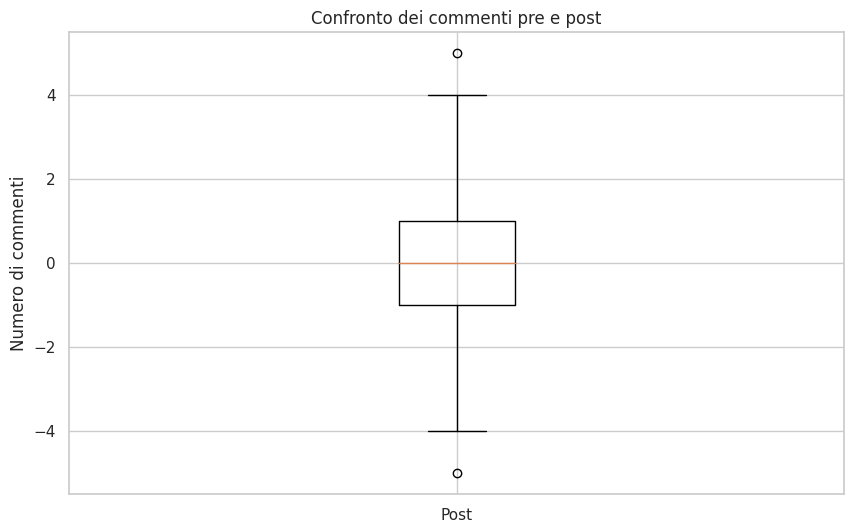

In [ ]:
final_results[['comment_count_pre','comment_count_post']]
final_results['difference_comments']=final_results['comment_count_post']-final_results['comment_count_pre']

plt.figure(figsize=(10, 6))
plt.boxplot([final_results['difference_comments']], labels=[ 'Post'])

# Aggiunta di titolo e etichette
plt.title('Confronto dei commenti pre e post')
plt.ylabel('Numero di commenti')

# Mostra il grafico
plt.show()

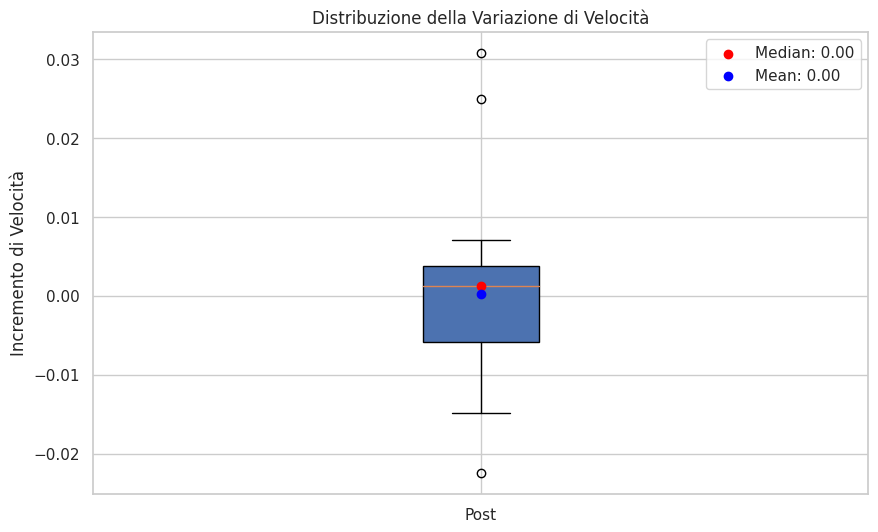

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Supponiamo che final_results sia già definito e contenga la colonna 'speed_increase'

# Calcolo di mediana e media
median_speed_increase = final_results['speed_increase'].median()
mean_speed_increase = final_results['speed_increase'].mean()

# Creazione del boxplot
plt.figure(figsize=(10, 6))
boxplot_data = plt.boxplot(final_results['speed_increase'], labels=['Post'], patch_artist=True)

# Aggiunta di mediana e media al grafico
plt.scatter(1, median_speed_increase, color='red', zorder=3, label=f'Median: {median_speed_increase:.2f}')
plt.scatter(1, mean_speed_increase, color='blue', zorder=3, label=f'Mean: {mean_speed_increase:.2f}')

# Aggiunta di titolo e etichette
plt.title('Distribuzione della Variazione di Velocità')
plt.ylabel('Incremento di Velocità')

# Aggiunta di legenda
plt.legend()

# Mostra il grafico
plt.show()


Se una piccola prte di utenti c'era nell'ora precedente e resta per quella successiva, entra nel vivo della conversazione quindi nel 65% dei casi l'IAT diminuisce.

# Grafo

In [172]:
import pandas as pd
from itertools import combinations
import pandas as pd
import networkx as nx
data['root_submission'].value_counts().reset_index()

data['created_at'] = pd.to_datetime(data['created_at'])

data = data.dropna(subset=['user'])

thread = data[data['root_submission'] == 3296292]
users=thread.user.dropna().unique()

user_pairs = list(combinations(users, 2))

edge_weights = []

for pair in tqdm(user_pairs):
    dates_set1 = thread[thread['user'] == pair[0]]['created_at']
    dates_set2 = thread[thread['user'] == pair[1]]['created_at']

    distances_1_2 = [min(abs(date1 - date2).total_seconds() for date2 in dates_set2) for date1 in dates_set1]
    distances_2_1 = [min(abs(date2 - date1).total_seconds() for date1 in dates_set1) for date2 in dates_set2]

    w_1_2 = 1 / (sum(distances_1_2) / (len(distances_1_2) ** 3)) if distances_1_2 else 0
    w_2_1 = 1 / (sum(distances_2_1) / (len(distances_2_1) ** 3)) if distances_2_1 else 0

    edge_weights.append((pair[0], pair[1], w_1_2))
    edge_weights.append((pair[1], pair[0], w_2_1))

edge_weights_df = pd.DataFrame(edge_weights, columns=['source', 'target', 'weight'])

print("DataFrame dei pesi degli archi:")
print(edge_weights_df)


100%|██████████| 946/946 [00:01<00:00, 714.29it/s]

DataFrame dei pesi degli archi:
                   source               target    weight
0                 Sherrie     RevDrStrangelove  0.002222
1        RevDrStrangelove              Sherrie  0.002222
2                 Sherrie       Not_a_redfugee  0.001025
3          Not_a_redfugee              Sherrie  0.001025
4                 Sherrie         Adminstrater  0.000994
...                   ...                  ...       ...
1887             revfelix         SmokeyMeadow  0.000487
1888         SmokeyMeadow  Monkeyshinerbot3000  0.000238
1889  Monkeyshinerbot3000         SmokeyMeadow  0.000083
1890             revfelix  Monkeyshinerbot3000  0.000465
1891  Monkeyshinerbot3000             revfelix  0.000087

[1892 rows x 3 columns]


In [173]:
# Create the graph
G = nx.Graph()
for _, row in edge_weights_df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    G.add_edge(source, target, weight=weight)



In [174]:
# Add toxicity value to each user
max_toxicity_scores = thread.groupby(['user'])['toxicity_score'].max().reset_index()
max_toxicity_scores_dict = dict(zip(max_toxicity_scores['user'], max_toxicity_scores['toxicity_score']))
for node in G.nodes():
    if node in max_toxicity_scores_dict:
        G.nodes[node]['max_toxicity_score'] = max_toxicity_scores_dict[node]>0.6
    else:
        G.nodes[node]['max_toxicity_score'] = None

In [175]:
# Prune Network
edge_weights = [weight for _, _, weight in G.edges(data='weight')]

weight_threshold = np.percentile(edge_weights, 90)

pruned_G = G.copy()
for edge in G.edges():
    source, target = edge
    weight = G.edges[edge]['weight']
    if weight < weight_threshold:
        pruned_G.remove_edge(source, target)

<ipython-input-176-3f7be2509b2c>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


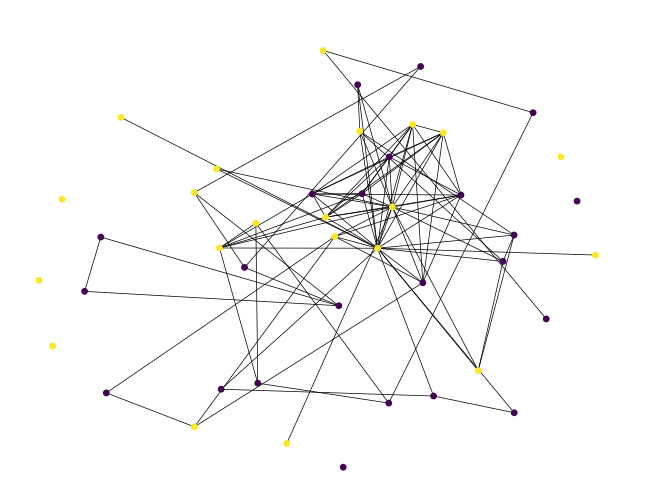

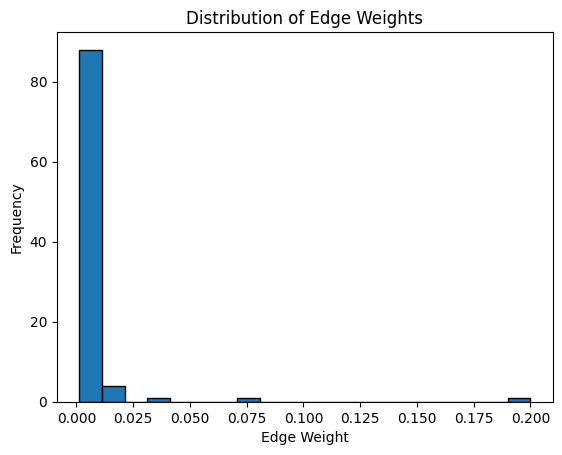

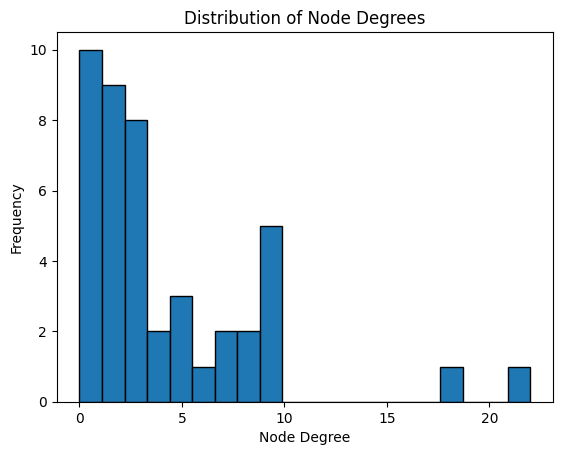

In [176]:
# Visualize Graph
cmap = plt.cm.get_cmap('viridis')
max_toxicity_scores = [G.nodes[node]['max_toxicity_score'] for node in G.nodes()]
norm = plt.Normalize(vmin=min(max_toxicity_scores), vmax=max(max_toxicity_scores))
node_colors = [cmap(norm(score)) if score is not None else 'gray' for score in max_toxicity_scores]
nx.draw(pruned_G, with_labels=False, node_size=15, width=0.52, node_color=node_colors)
plt.show()

# Distribution of edge weights
edge_weights = [pruned_G.edges[edge]['weight'] for edge in pruned_G.edges()]
plt.hist(edge_weights, bins=20, edgecolor='black')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights')
plt.show()

# Distribution of node degrees
node_degrees = [degree for _, degree in pruned_G.degree()]
plt.hist(node_degrees, bins=20, edgecolor='black')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Node Degrees')
plt.show()



In [177]:
# Dato un utente, tossico o no, tra i suo amici c'è un tossico?
x_values=[]
y_values=[]

for node in pruned_G.nodes():
    max_toxicity_score = pruned_G.nodes[node]['max_toxicity_score']

    neighbors = list(pruned_G.neighbors(node))
    weights = [pruned_G[node][neighbor].get('weight', 1) for neighbor in pruned_G.neighbors(node)]
    normalized_weights = [(weight - min(weights)) / (max(weights) - min(weights)) if max(weights) != min(weights) else 1 for weight in weights] if weights else []


    if neighbors:
        toxicity_scores_neighbors = [pruned_G.nodes[neighbor].get('max_toxicity_score', 0) for neighbor in neighbors]
        numeric_list = [1 if value else 0 for value in toxicity_scores_neighbors]
        median_toxicity_score_neighbors = np.mean([a * b for a, b in zip(normalized_weights, toxicity_scores_neighbors)])
    else:
        median_toxicity_score_neighbors = None

    x_values.append(max_toxicity_score)
    y_values.append(median_toxicity_score_neighbors)

df = pd.DataFrame({'x': x_values, 'y': y_values})
df=df.dropna()

tossico: 0.30427793686515925
non tossico: 0.26291082690281087


<Figure size 1000x600 with 0 Axes>

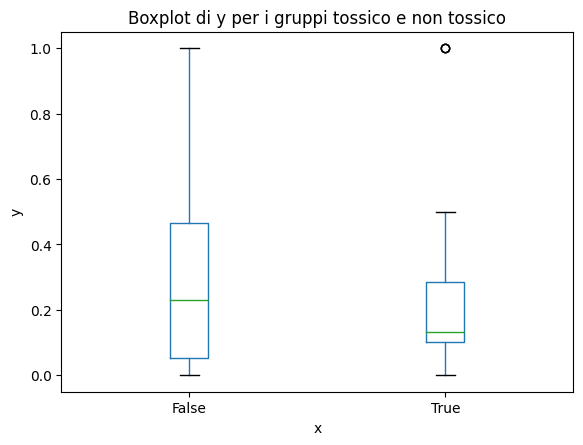

T-statistic: 0.4204649036633142
P-value: 0.6766451893754803


In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Supponiamo che il DataFrame df sia già caricato

# Calcolare le medie dei valori di 'y' per i gruppi definiti da 'x'
mean_tossico = np.mean(df[df['x']]['y'])
mean_non_tossico = np.mean(df[~df['x']]['y'])

print('tossico:', mean_tossico)
print('non tossico:', mean_non_tossico)

# Stampare i boxplot dei due gruppi
plt.figure(figsize=(10, 6))
df.boxplot(column='y', by='x', grid=False)
plt.title('Boxplot di y per i gruppi tossico e non tossico')
plt.suptitle('')  # Rimuove il titolo automatico generato da pandas
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Eseguire un test di indipendenza (t-test) tra i due gruppi
group_tossico = df[df['x']]['y']
group_non_tossico = df[~df['x']]['y']

t_stat, p_value = ttest_ind(group_tossico, group_non_tossico)

print('T-statistic:', t_stat)
print('P-value:', p_value)


In [179]:
# Creiamo la tabella di contingenza
contingency_table = pd.crosstab(df['x'], df['y'])

print("Tabella di Contingenza:")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nRisultati del Test del Chi Quadro:")
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Tabella di Contingenza:
y      0.000000  0.005104  0.053587  0.054264  0.068447  0.099949  0.100731  \
x                                                                             
False         4         0         1         1         1         0         0   
True          2         1         0         0         0         1         1   

y      0.113517  0.116762  0.116903  ...  0.229716  0.255022  0.268764  \
x                                    ...                                 
False         0         0         0  ...         1         1         0   
True          1         1         1  ...         0         0         1   

y      0.273914  0.283865  0.286775  0.333333  0.464514  0.500000  1.000000  
x                                                                            
False         0         1         0         2         1         4         1  
True          1         0         1         0         0         1         3  

[2 rows x 25 columns]

Risultati del Test del Chi